# Nortek AD2CP Processing, Testing, and Data Exploration

jgradone@marine.rutgers.edu     01/11/2022    Initial

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>


*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys
from datetime import datetime


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
from make_dataset import correct_sound_speed, beam_true_depth, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform
from analysis import get_erddap_dataset

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [2]:
ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.0,18.172288,-64.968623,2021-09-08T19:43:16.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
1,NaN,18.172288,-64.968623,2021-09-08T19:43:22.01Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
2,0.0,18.172288,-64.968623,2021-09-08T19:43:23.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
3,NaN,18.172288,-64.968623,2021-09-08T19:44:26.30Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
4,NaN,18.172270,-64.968681,2021-09-08T19:44:52.37Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1453164,NaN,NaN,NaN,2021-10-07T19:57:17.47Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453165,NaN,NaN,NaN,2021-10-07T19:57:23.31Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453166,NaN,NaN,NaN,2021-10-07T19:57:30.35Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453167,NaN,NaN,NaN,2021-10-07T19:57:34.80Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN


## Step 2: Load in AD2CP data frame

In [3]:
# path = '/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/'
path = '/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/'
files = np.sort(glob.glob(path+'*.nc'))

tot_ad2cp = xr.open_mfdataset(files,group='Data/Burst/', concat_dim="time", combine="nested")
## I think this is a documented bug in the xarray open_mfdataset function for grouped NetCDFs
config = xr.open_dataset(files[0],group='Config')
## So, just assigning the global attributes from the first file to the combined file
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
tot_ad2cp = tot_ad2cp.rename({'Velocity Range':'VelocityRange','Correlation Range':'CorrelationRange','Amplitude Range':'AmplitudeRange'})
# 2 House-keeping steps
# 1) Roll shifted 180 for some reason
tot_ad2cp['Roll'] = tot_ad2cp['Roll']-180
# 2) Surface depth is 10 meters. Needed for at least for the 2020 and both 2021 deployments, per conversations with Sven from Nortek.
tot_ad2cp['Pressure'] = tot_ad2cp['Pressure']-10
# Put time on x-dimension
tot_ad2cp = tot_ad2cp.transpose()
tot_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 9192584, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-10-04T12:52:51.9070...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/52)
    VelocityBeam1              (VelocityRange, time) float32 dask.array<chunksize=(40, 148123), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 dask.array<chunksize=(40, 148123), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 dask.array<chunksize=(40, 148123), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 dask.array<chunksize=(40, 148123), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 148123), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 148123), meta=np.ndarray>
    ...                         ...
    QuaternionX                (time) float32 dask.array<chunksize=(148123,), meta=np.ndarray>
    QuaternionY                (time) float32 dask.array<chunksize=(148123,), meta=np.ndarray>
    QuaternionZ                (time) float32 dask.array<chunksize=(148123,), meta=np.ndarray>
    AHRSGyroX                  (time) float32 dask.array<chunksize=(148123,), meta=np.ndarray>
    AHRSGyroY                  (time) float32 dask.array<chunksize=(148123,), meta=np.ndarray>
    AHRSGyroZ                  (time) float32 dask.array<chunksize=(148123,), meta=np.ndarray>
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             373714906.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

## Step 3: Subset datasets
Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data

In [22]:
## Just one file for testing
x = 28

## Subset glider df to one segment
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
## Pull out last non-NaN DAC
ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
vx_lon      = np.nanmean(subsetgdf.longitude)
vx_lat      = np.nanmean(subsetgdf.latitude)
vx_start_tm = subsetgdf.time.iloc[0]
vx_end_tm   = subsetgdf.time.iloc[-1]

## Subset AD2CP dataframe based on segment start and end times
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

## Take a quick peak at some data

/tmp/ipykernel_30995/2703616999.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])


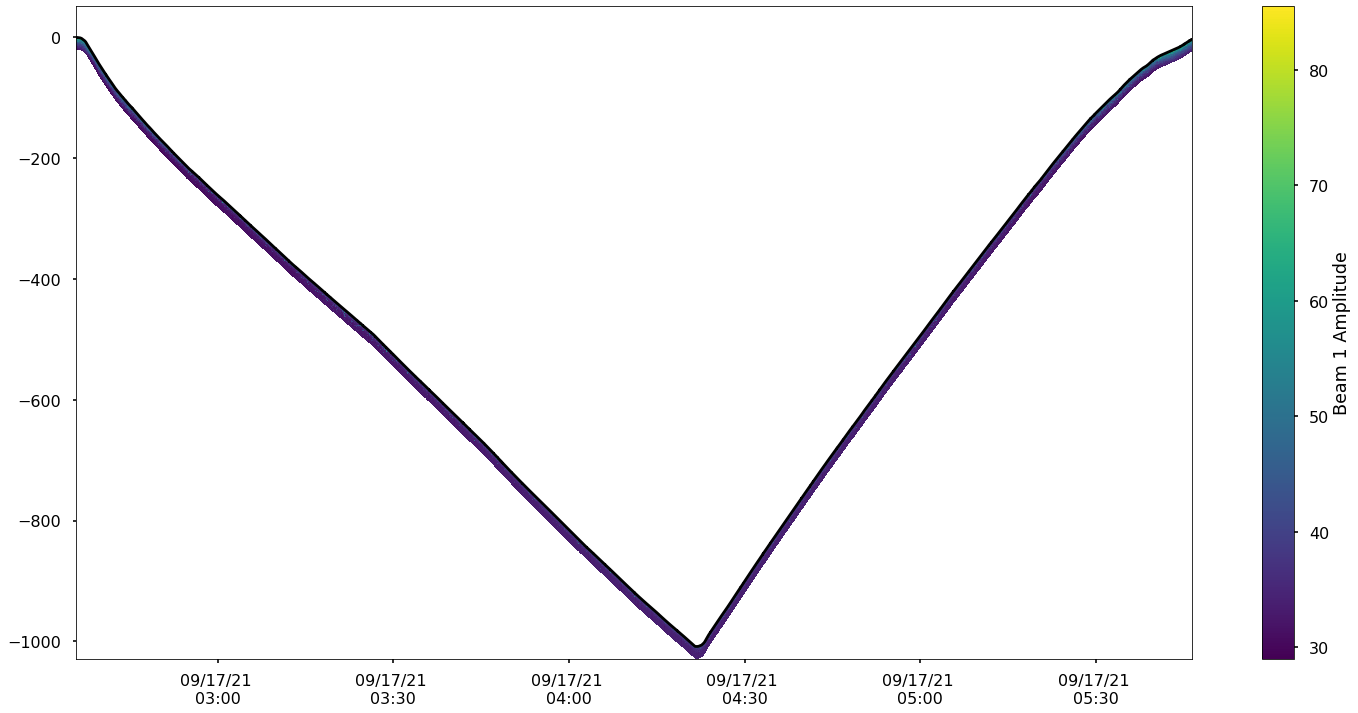

In [23]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

### Zoomed in peak at data

/tmp/ipykernel_30995/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


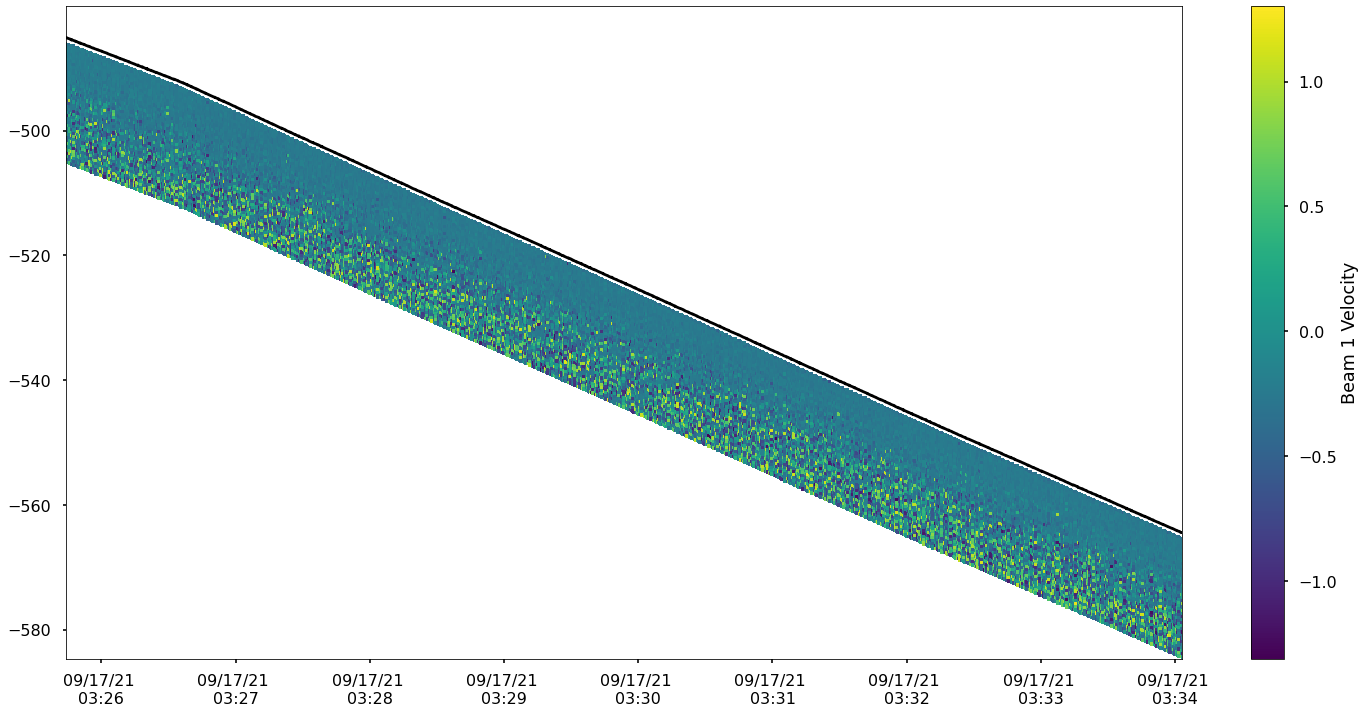

In [24]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Step 4: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

In [25]:
np.max(subset_ad2cp.VelocityBeam1.values)

1.315

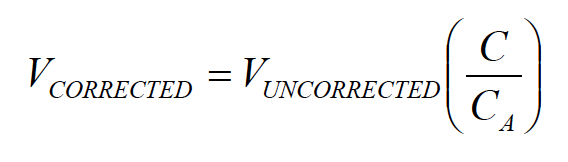

In [26]:
## Correct for local speed of sound
subset_ad2cp = correct_sound_speed(subset_ad2cp)

In [27]:
np.max(subset_ad2cp.VelocityBeam1.values)

1.3291061

### Take a peak at the speed of sound corrected data

/tmp/ipykernel_30995/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


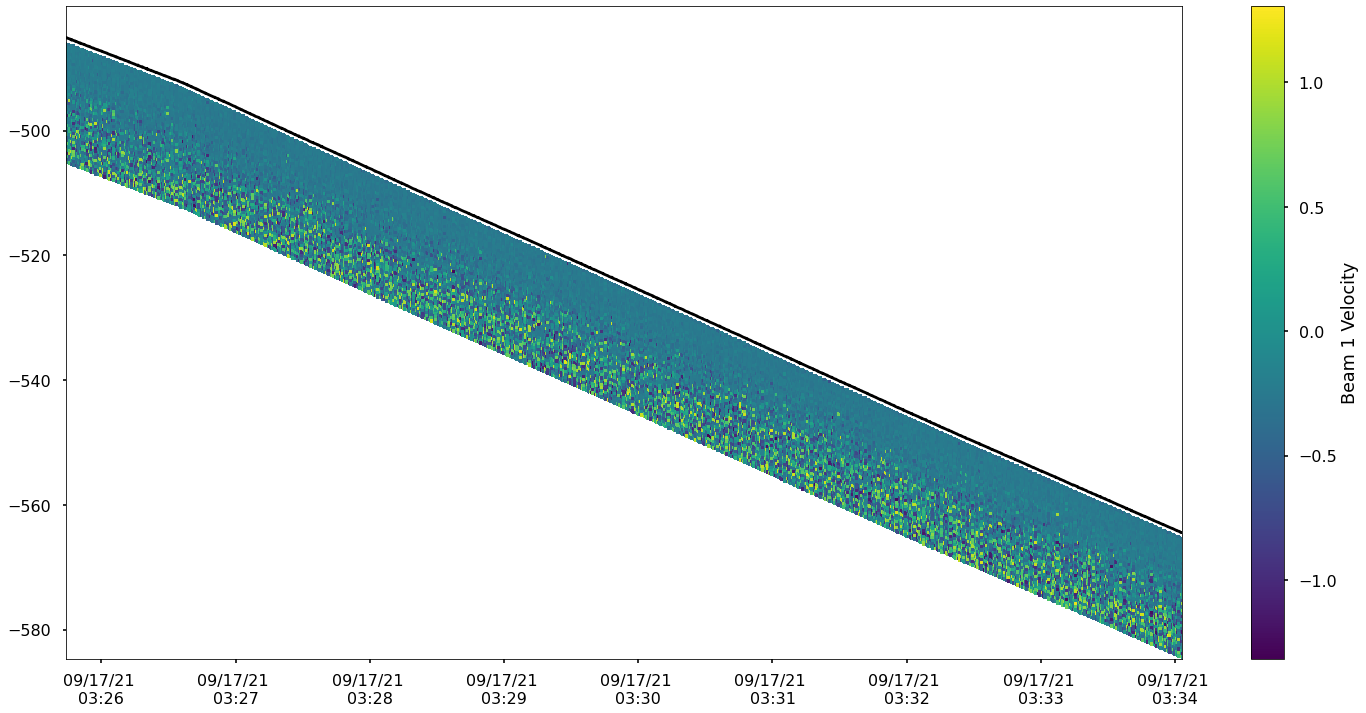

In [28]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Step 5: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [29]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

-0.20359509

In [30]:
## QAQC pre-coordinate transformation
subset_ad2cp = qaqc_pre_coord_transform(subset_ad2cp)

In [31]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

-0.25633237

### Take a peak at the QAQC'd data

/tmp/ipykernel_30995/1663250550.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])


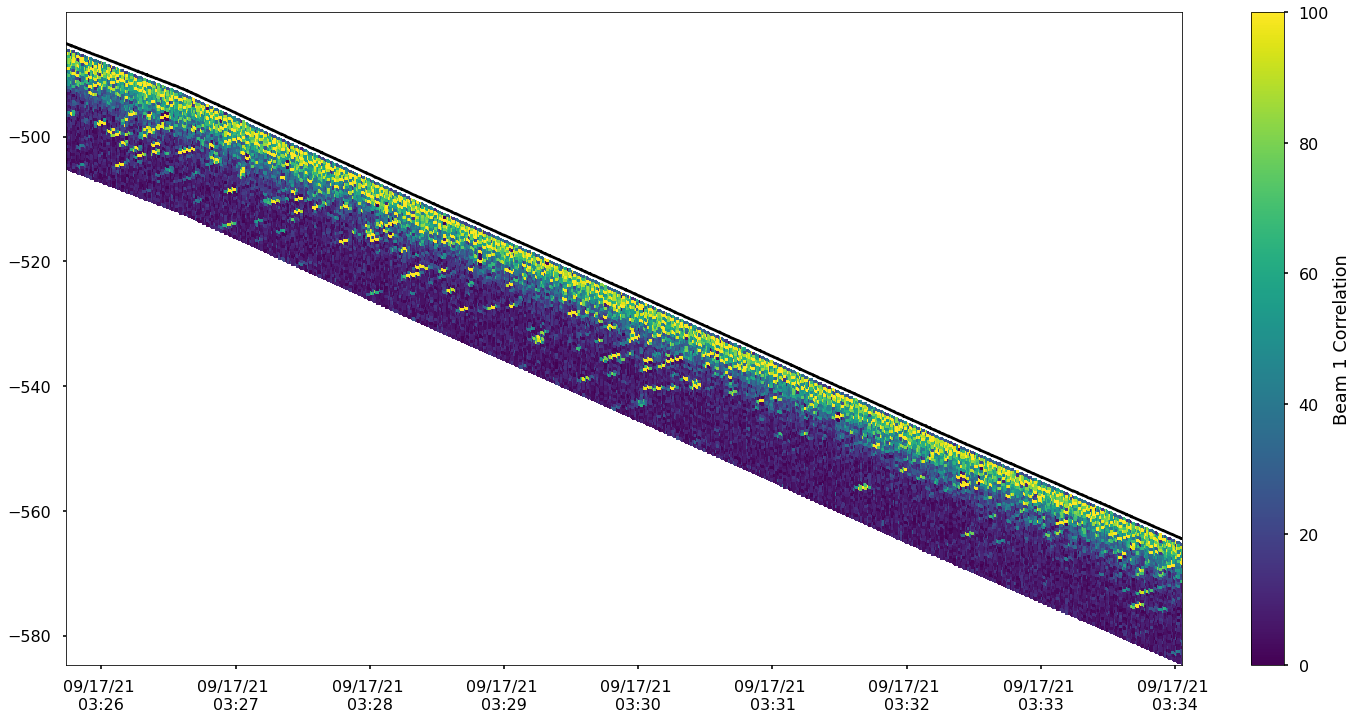

In [32]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Correlation')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_30995/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


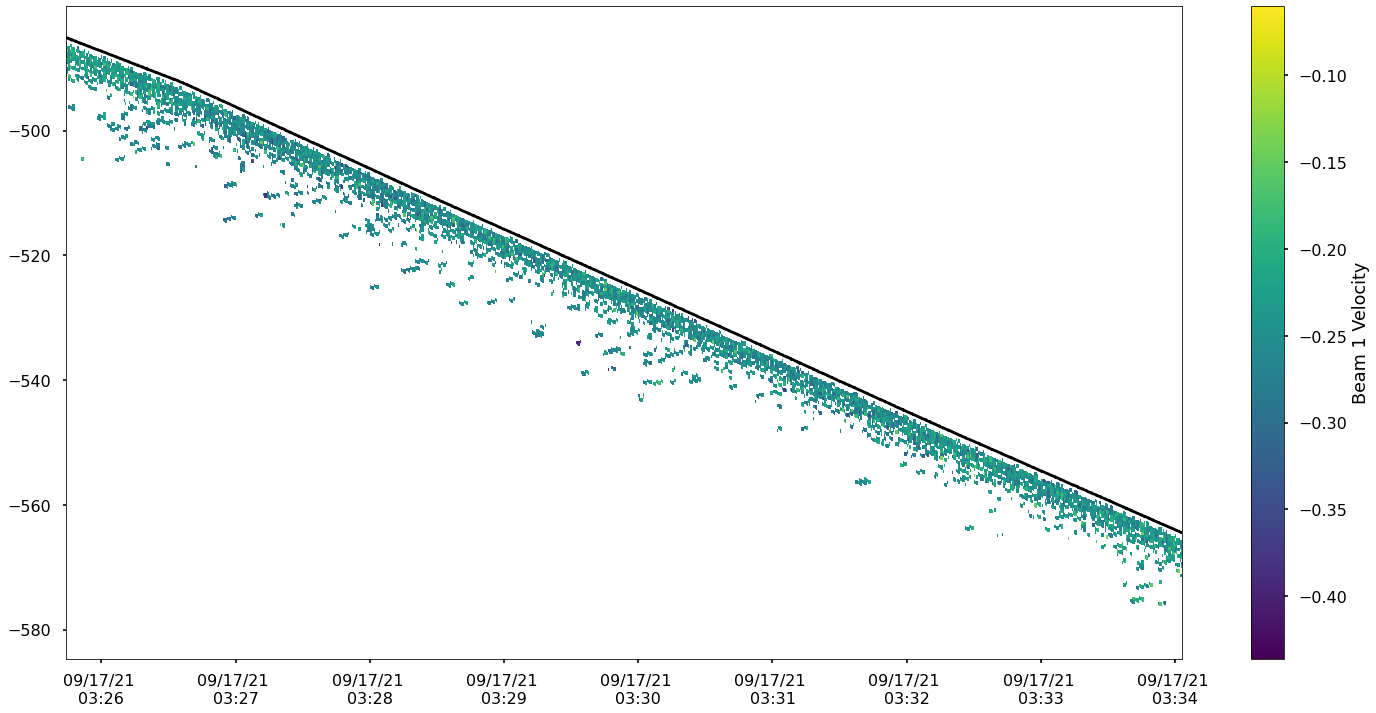

In [33]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 6: Correct beams to level true-depth

In [34]:
## Correct beams to level true-depth
subset_ad2cp = beam_true_depth(subset_ad2cp)

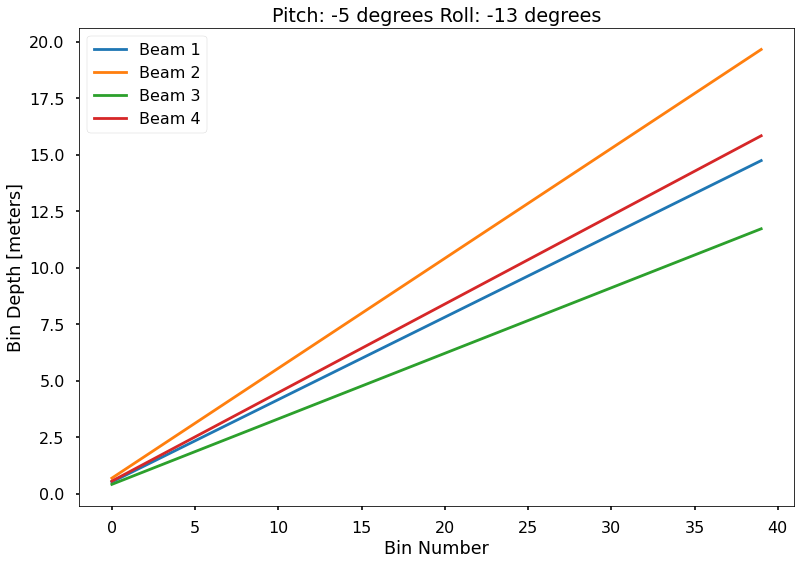

In [35]:
x=20
plt.plot(subset_ad2cp.TrueDepthBeam1.values[:,x],label='Beam 1')
plt.plot(subset_ad2cp.TrueDepthBeam2.values[:,x],label='Beam 2')
plt.plot(subset_ad2cp.TrueDepthBeam3.values[:,x],label='Beam 3')
plt.plot(subset_ad2cp.TrueDepthBeam4.values[:,x],label='Beam 4')
plt.ylabel('Bin Depth [meters]')
plt.xlabel('Bin Number')
plt.title('Pitch: %i' %subset_ad2cp['Pitch'].values[x] + ' degrees Roll: %i' %subset_ad2cp['Roll'].values[x] + ' degrees')
plt.legend()

## Processing Step 7: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [36]:
## Bin map
subset_ad2cp = binmap_adcp(subset_ad2cp)

### Take a peak at the bin mapped data

/tmp/ipykernel_30995/1114724160.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])


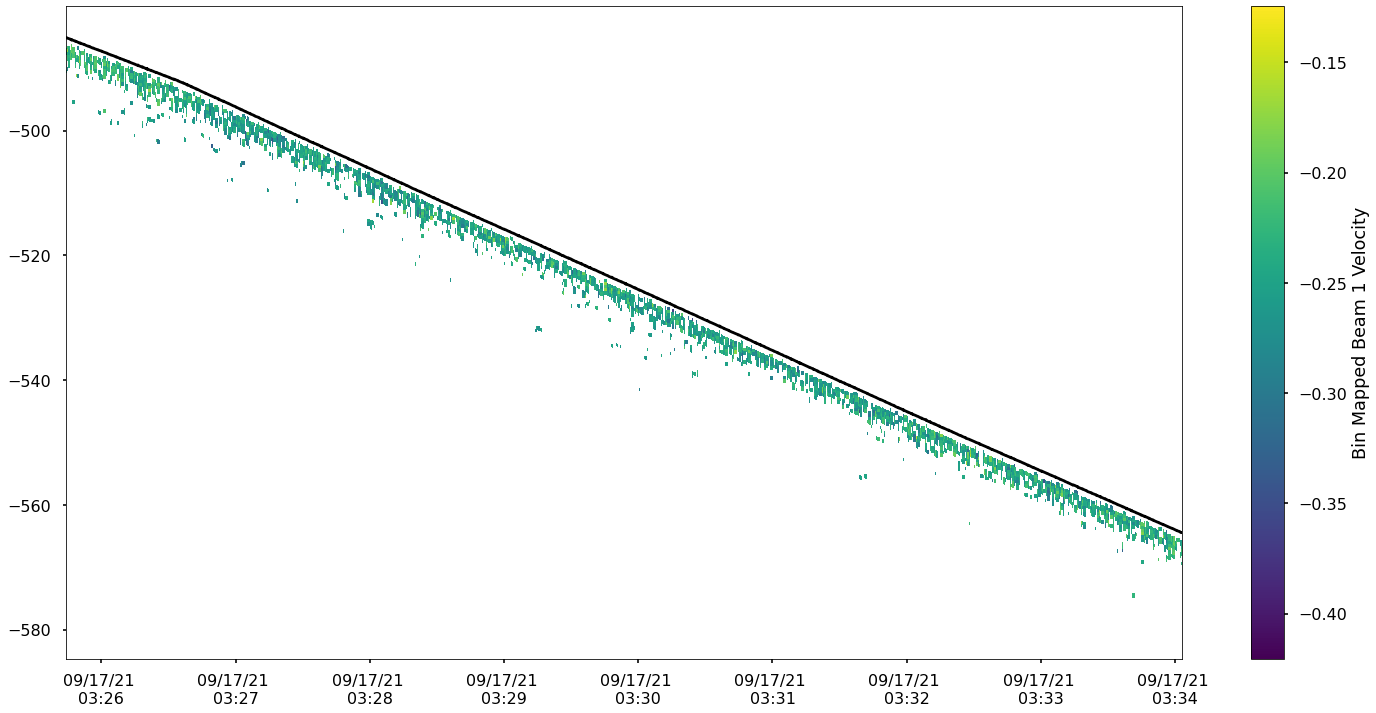

In [37]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Bin Mapped Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 8: Convert from Beam to XYZ to ENU coordinates

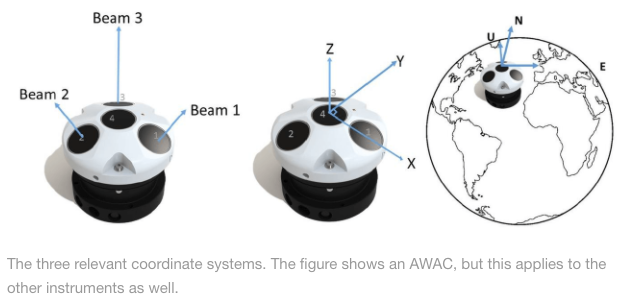

In [38]:
## Beam to ENU
subset_ad2cp = beam2enu(subset_ad2cp)

### Take a peak at ENU data

/tmp/ipykernel_30995/1788961314.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])


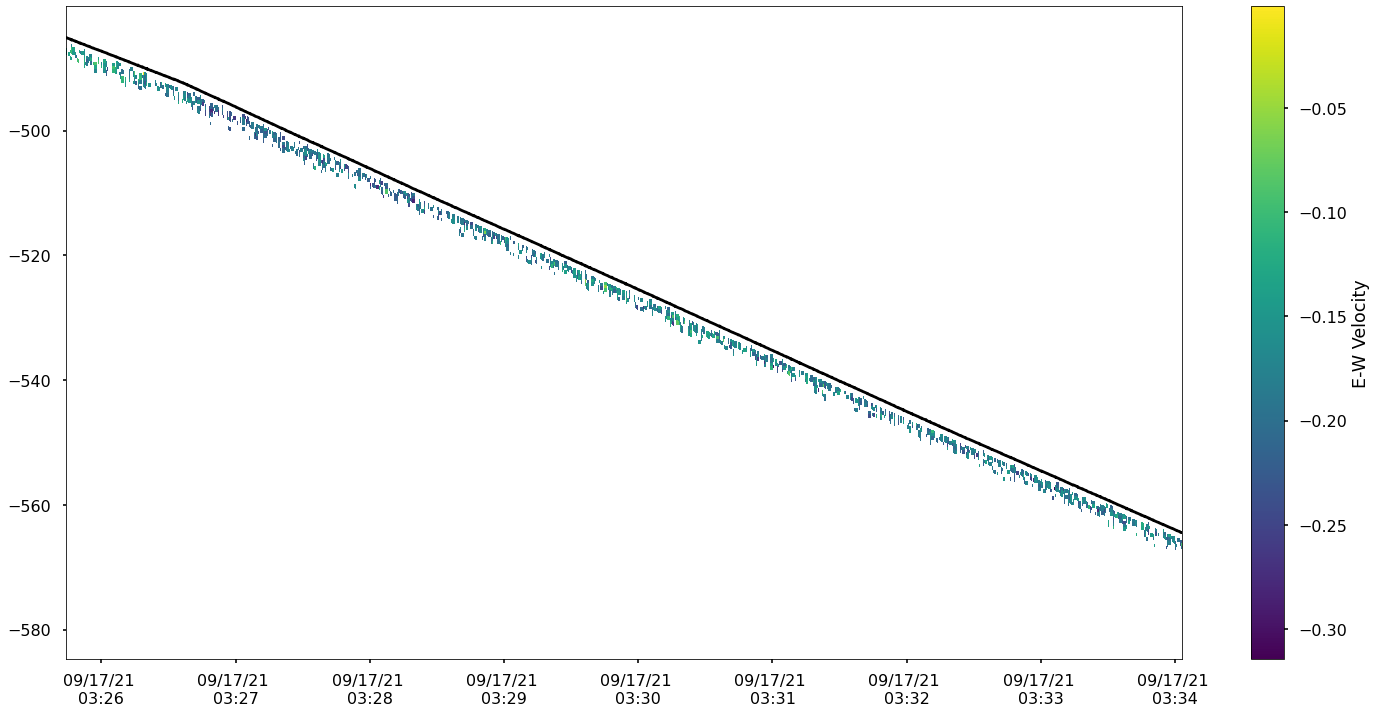

In [39]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='E-W Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 9: Run the inversion!

In [40]:
## Now ready for inversion!
O_ls, G_ls, bin_new = inversion(U=subset_ad2cp.UVelocity.transpose().values,V=subset_ad2cp.VVelocity.transpose().values,H=1000,dz=10,u_daverage=vx,v_daverage=vy,bins = subset_ad2cp['VelocityRange'], depth = subset_ad2cp['Pressure'])

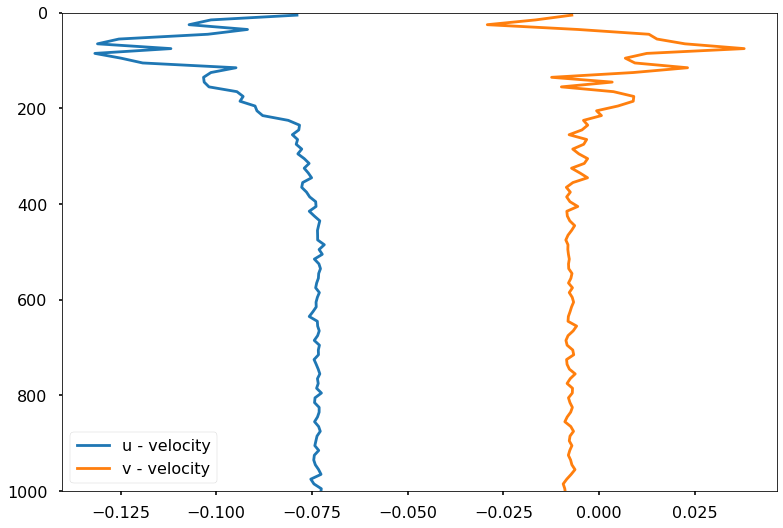

In [41]:
plt.plot(np.real(O_ls),bin_new,label='u - velocity')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
plt.ylim(1000,0)
plt.legend()

# Testing and Data Exploration

### Checking on pitch vattery-dependent magnetic heading correction

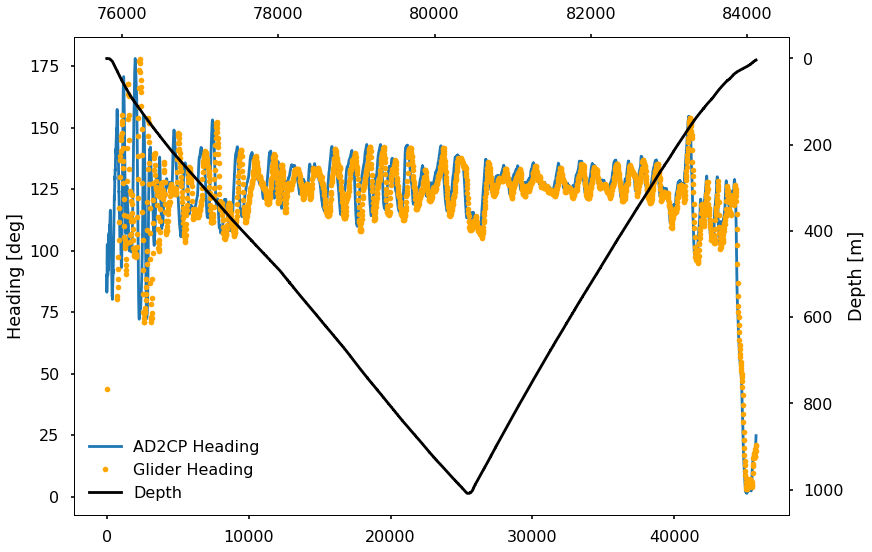

In [42]:
x=28
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])


fig,ax = plt.subplots()

ln1 = ax.plot(subset_ad2cp.Heading.values,label='AD2CP Heading')
ax2=ax.twiny()
ln2 = ax2.plot(np.rad2deg(subsetgdf.m_heading),'.',color='orange',label='Glider Heading')
ax.set_ylabel('Heading [deg]')
ax3=ax.twinx()
ln3 = ax3.plot(subset_ad2cp.Pressure.values,color='black',label='Depth')
ax3.invert_yaxis()
ax3.set_ylabel('Depth [m]')
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower left',frameon=False)

### Sweet, data looks good.